In [1]:
import matplotlib.pyplot as plt
from spacepy import pycdf
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.axis import Axis
from matplotlib import colors
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from matplotlib.lines import Line2D
from scipy.special import voigt_profile
import scipy.stats as st
from matplotlib.ticker import MaxNLocator

c:\Users\franc\anaconda3\Lib\site-packages\spacepy\time.py:2341: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [3]:
class type_III_lab:
    
    def __init__(self, date, start_event, end_event, filepath):
        self.date = date
        self.start_event = start_event
        self.end_event = end_event
        self.filepath = filepath
    
    @staticmethod
    def to_timestamp(array): # Converts datetime arrays into timestamp arrays
        timestamps = list(map(lambda x: datetime.timestamp(x), array))
        return timestamps
    @staticmethod
    def to_date(array): # Converts timestamp arrays into datetime arrays
        mydates = list(map(lambda x: datetime.fromtimestamp(x), array))
        return mydates
    @staticmethod
    def halfpeak_avg(a):
        peak_condition = np.where(a >= 0.8*np.max(a))
        peak_arr = a[peak_condition]
        return np.average(peak_arr)
    @staticmethod
    def halfpeak_err(a):
        peak_condition = np.where(a >= 0.8*np.max(a))
        peak_arr = a[peak_condition]
        return np.std(peak_arr)
    
    def data(self):
        cdf_file = pycdf.CDF(self.filepath)
        freq, flux, time = cdf_file['frequency_lfr_auto_averages_ch0_V1V2'][...][0]/1000, np.transpose(cdf_file['psp_fld_l3_rfs_lfr_PSD_SFU'][...]), cdf_file['epoch_lfr_auto_averages_ch0_V1V2'][...]
        
        yyyy, mm, dd = self.date.split('-')
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        time_start = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_s), int(MM_s), int(SS_s))
        time_end = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_e), int(MM_e), int(SS_e))
        
        def time_inter(t_arr):
            start = np.abs(np.array(t_arr)-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(t_arr)-datetime.timestamp(time_end)).argmin()
            return [start, end]
        
        def time_back(t_arr):
            start = np.abs(np.array(t_arr)-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(t_arr)-datetime.timestamp(time_start) - 600).argmin()
            return [start, end]
        
        back_start = time_back(self.to_timestamp(time))[0]
        back_end = time_back(self.to_timestamp(time))[1]
        flux_back = np.median(flux[:, back_start:back_end], axis=1)
        
        start = time_inter(self.to_timestamp(time))[0]
        end = time_inter(self.to_timestamp(time))[1]
        
        num = len(flux[0, start:end])
        background = np.transpose(np.tile(flux_back, (num, 1)))
        flux_2d = flux[:, start:end] - background
        flux_2d = np.where(flux_2d <=np.average(background)/100, np.average(background)/100, flux_2d)
        
        my_dict = {'time': time[start:end], 'freq': freq, 'flux': flux_2d, 'background': background}
        
        return my_dict
        
    def dyn_spec(self, show, save, max_f, min_f, theta_0, val):
        
        d = type_III_lab(self.date, self.start_event, self.end_event, self.filepath)
        flux, time, freq = d.data()['flux'], d.data()['time'], d.data()['freq']
        t_correct = time[0].timestamp()
        time_resolution = np.min(np.ediff1d(self.to_timestamp(time)))/2
        
        def arg_peak(a, b):
            peak_condition = np.where(a >= val*np.max(a))
            peak_arr = np.array(b)[peak_condition]
            unc = (np.max(peak_arr) - np.min(peak_arr))/2
            return unc
        
        def arg_midpeak(a):
            peak_condition = np.where(a >= val*np.max(a))
            peak_arg = (np.max(peak_condition) + np.min(peak_condition))/2
            return int(peak_arg)
        
        def sig_correct(a):
            for i in range(1,len(a)):
                if a[i] <= time_resolution:
                    a[i] = time_resolution
            return a
        
        max_flux = list(map(lambda i: time[arg_midpeak(flux[i])], range(0, len(freq))))
        
        yyyy, mm, dd = self.date.split('-')
        date_plot = dd + '-' + mm + '-' + yyyy
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        
        freq_range = np.where((freq<=max_f)&(freq>=min_f))
        ts = np.array([t.timestamp() for t in max_flux])
        
        t_res = sig_correct(np.array(list(map(lambda i: arg_peak(flux[i,:],  self.to_timestamp(time)), range(0, len(freq))))))[freq_range] 
        
        gamma, delta = 8.9e-3*np.sqrt(1.4e6), -2.3/2
        def freq_model(r):
            return 8.9*np.sqrt(1.4e6/(r**2.3))
        
        def dist_model(f):
            return ((f/8.9)**2 / 1.4e6)**(-1/2.3)
        
        def t(f, A, B, C):
            T = (f/(1000*A))**(1/B) + C
            return T
        
        max_flux_freq = list(map(lambda i: freq[flux[:,i].argmax()], range(0, len(time))))
        ts_freq = np.array([t.timestamp() for t in time])
        
        myFmt = mdates.DateFormatter('%H:%M')
        
        fig1 = plt.figure(figsize=(32,9))
        ax_0 = fig1.add_gridspec(1, 2,  wspace=0.09, width_ratios=[1.6, 1.4])
        ax_0_a = ax_0[0].subgridspec(1, 1, width_ratios=[1])
        ax_0_b = ax_0[1].subgridspec(1, 2, wspace=0.06, width_ratios=[2.4,0.6])
        ax0a = [fig1.add_subplot(ax_0_a[0, 0])]
        ax0b = [fig1.add_subplot(ax_0_b[0, 0]), fig1.add_subplot(ax_0_b[0, 1])]
        
        fig2 = plt.figure(figsize=(32,9))
        ax_1 = fig2.add_gridspec(1, 3,  wspace=0.28, width_ratios=[1, 1, 1])
        ax1 = [fig2.add_subplot(ax_1[0, 0]), fig2.add_subplot(ax_1[0, 1]), fig2.add_subplot(ax_1[0, 2])]
        
        ax_spectro, ax_res, ax_r, ax_vc, ax_vc_r, ax_ac = ax0a[0], ax0b[1], ax0b[0], ax1[0], ax1[1], ax1[2]
        
        flux = np.where(flux<=0, np.min(np.abs(flux[np.isfinite(flux)])), flux)
        Spectrum = np.max(flux)*(flux - np.min(flux))/(np.max(flux) - np.min(flux)) + 0.1
        v_min_val, v_max_val =  np.min(Spectrum) + 3000, (np.max(Spectrum) + np.min(Spectrum))/2
    
        T,F = np.meshgrid(time, freq)
        im = ax_spectro.pcolormesh(T, F, flux, norm=colors.LogNorm(vmin=v_min_val , vmax=v_max_val), cmap=cm.inferno)

        cbar = fig1.colorbar(im)
        cbar.ax.tick_params(labelsize=29)
        cbar.set_label('PSP (SFU)', fontsize=37, labelpad=10)
        
        ax_spectro.scatter(max_flux, freq, s=100, c='g', marker='x', label='Maximum Flux')
        ax_spectro.xaxis.set_major_formatter(myFmt)
        ax_spectro.tick_params(axis='y', which='both', labelsize=29, length=5, width=1, direction='out', right=False)
        ax_spectro.tick_params(axis='y', which='both', labelsize=29, length=5, width=1)
        ax_spectro.tick_params(axis='x', which='both', labelsize=29, length=5, width=1)
        ax_spectro.set_ylim(250, np.max(freq))
        ax_spectro.set_yscale("log")
        ax_spectro.set_ylabel('Frequency (kHz)', fontsize=37)
        
        if show == 'show':
            
            ax_spectro.set_xlabel('Time (HH:MM)', fontsize=37)
            
            guess_par = [194, -1, 700]
            parameters, covariance = curve_fit(t, freq[freq_range], ts[freq_range] - t_correct, sigma=t_res, p0=guess_par, absolute_sigma=True, maxfev=200000)
            parameters_h, covariance_h = curve_fit(t, freq[freq_range]/2, ts[freq_range] - t_correct, sigma=t_res, p0=guess_par, absolute_sigma=True, maxfev=200000)
            
            f_fit = freq[freq_range]
            t_fit_result = np.int64(t(freq[freq_range], *parameters)) + np.int64(t_correct)
            t_fit = self.to_date([t for t in t_fit_result])
            
            ax_spectro.plot(t_fit, f_fit, 'g', linestyle='--', linewidth=3.5) #, label=r'f[MHz] = $\frac{' + str('%.2e' % (parameters[2])) + ' \pm ' + str('%.2e' % np.sqrt(covariance[2,2])) + '}{(t[s] - t_{0})^{' + str('%.2e' % parameters[0]) + ' \pm ' + str('%.2e' % np.sqrt(covariance[0,0])) + '}}$')        
            ax_spectro.hlines(np.max(f_fit), datetime.fromtimestamp(np.min(ts[freq_range])), datetime.fromtimestamp(np.max(ts[freq_range])), 'g', linestyle='--', linewidth=3.5)
            ax_spectro.hlines(np.min(f_fit), datetime.fromtimestamp(np.min(ts[freq_range])), datetime.fromtimestamp(np.max(ts[freq_range])), 'g', linestyle='--', linewidth=3.5)
            ax_spectro.vlines(datetime.fromtimestamp(np.min(ts[freq_range])), np.min(f_fit), np.max(f_fit),'g', linestyle='--', linewidth=3.5)
            ax_spectro.vlines(datetime.fromtimestamp(np.max(ts[freq_range])), np.min(f_fit), np.max(f_fit),'g', linestyle='--', linewidth=3.5)
                
            r = np.linspace(2, 215, 1000)
            dist = dist_model(freq[freq_range])
            dist_h = dist_model(freq[freq_range]/2)
            t_to_fit = ts[freq_range]
            w_pe = 2*np.pi*freq[freq_range]

            def sum_err(a):
                N = len(a)
                return np.sqrt(np.sum(a**2))/N
            
            p = 3

            r_to_c = 7/3
            t_0 = 7*(dist-np.min(dist))*np.cos(np.pi*theta_0/180)/3
            t_0_h = 7*(dist_h-np.min(dist_h))*np.cos(np.pi*theta_0/180)/3
            
            guess = [0.3, 0.7, 900]
            sig_dt = t_res
            t_to_fit = ts[freq_range] - t_correct
            bounds_t = [[-np.inf, -np.inf, -np.inf], [np.inf,np.inf,np.inf]]
            
            guess_par = [194, -1, 700]
            par, cov = curve_fit(t, freq[freq_range], t_to_fit - t_0, sigma=sig_dt, method='trf', bounds=bounds_t, p0=guess_par, absolute_sigma=True, maxfev=200000)
            par_h, cov_h = curve_fit(t, freq[freq_range]/2, t_to_fit - t_0_h, sigma=sig_dt, method='trf', bounds=bounds_t, p0=guess_par, absolute_sigma=True, maxfev=200000)
            
            res = t_to_fit - t_0 - t(freq[freq_range], *par)
            res_h = t_to_fit - t_0_h - t(freq[freq_range]/2, *par_h)
            
            chisq = np.sum((res/sig_dt)**2)/(len(dist) - p)
            chisq_h = np.sum((res_h/sig_dt)**2)/(len(dist_h) - p)
            
            A, B, C = par[0], par[1], par[2]
            A_h, B_h, C_h = par_h[0], par_h[1], par_h[2]
            
            alpha, d_alpha  = r_to_c * B/delta * (A/gamma)**(1/B), r_to_c * np.sqrt(cov[0,0]*((A/gamma)**(1/B -1) / delta / gamma)**2 + cov[1,1]*(-np.log(A/gamma)*(A/gamma)**(1/B)/B/delta + (A/gamma)**(1/B)/delta)**2 + 2*cov[1,0]*(-np.log(A/gamma)*(A/gamma)**(1/B)/B/delta + (A/gamma)**(1/B)/delta)*((A/gamma)**(1/B -1) / delta / gamma))
            beta, d_beta = 1 - delta/B, np.abs(delta/B**2)*np.sqrt(cov[1,1])
            alpha_h, d_alpha_h  = r_to_c * B_h/delta * (A_h/gamma)**(1/B_h), r_to_c * np.sqrt(cov_h[0,0]*((A_h/gamma)**(1/B_h -1) / delta / gamma)**2 + cov_h[1,1]*(-np.log(A_h/gamma)*(A_h/gamma)**(1/B_h)/B_h/delta + (A_h/gamma)**(1/B_h)/delta)**2 + 2*cov_h[1,0]*(-np.log(A_h/gamma)*(A_h/gamma)**(1/B_h)/B_h/delta + (A_h/gamma)**(1/B_h)/delta)*((A_h/gamma)**(1/B_h -1) / delta / gamma))
            beta_h, d_beta_h = 1 - delta/B_h, np.abs(delta/B_h**2)*np.sqrt(cov_h[1,1])
            
            alpha_w, d_alpha_w  = (1/2/np.pi/gamma)**(1/delta - 1/B)*alpha, (1/2/np.pi/gamma)**(1/delta - 1/B)*d_alpha
            beta_w, d_beta_w = beta/delta, np.abs(d_beta/delta)
            alpha_w_h, d_alpha_w_h  = (1/2/np.pi/gamma)**(1/delta - 1/B_h)*alpha_h, (1/2/np.pi/gamma)**(1/delta - 1/B_h)*d_alpha_h
            beta_w_h, d_beta_w_h = beta_h/delta, np.abs(d_beta_h/delta)
            
            c1, d_c1  = 7e5*B/delta*(B/delta-1)*(A/gamma)**(2/B), 7e5*np.sqrt(cov[0,0]*(2/delta/gamma *(A/gamma)**(2/B-1)*(B/delta-1))**2 + cov[1,1]*((2*B/delta**2 - 1/delta)*(A/gamma)**(2/B) - 2/B/delta *(B/delta -1)*np.log(A/gamma)*(A/gamma)**(2/B))**2 + 2*cov[1,0]*((2*B/delta**2 - 1/delta)*(A/gamma)**(2/B) - 2/B/delta *(B/delta -1)*np.log(A/gamma)*(A/gamma)**(2/B))*(2/delta/gamma *(A/gamma)**(2/B-1)*B/delta*(B/delta-1)))
            c2, d_c2 = 1 - 2*delta/B, np.abs(2*delta/B**2)*np.sqrt(cov[1,1])
            c1_h, d_c1_h  = 7e5*B_h/delta*(B_h/delta-1)*(A_h/gamma)**(2/B_h), 7e5*np.sqrt(cov_h[0,0]*(2/B_h/gamma *(A_h/gamma)**(2/B_h-1)*B_h/delta*(B_h/delta-1))**2 + cov_h[1,1]*((2*B_h/delta**2 - B_h/delta)*(A_h/gamma)**(2/B_h) - B_h/delta*(B_h/delta-1)*np.log(A_h/gamma)*(A_h/gamma)**(2/B_h)*2/B_h)**2 + 2*cov_h[1,0]*((2*B_h/delta**2 - B_h/delta)*(A_h/gamma)**(2/B_h) - B_h/delta*(B_h/delta-1)*np.log(A_h/gamma)*(A_h/gamma)**(2/B_h)*2/B_h)*(2/B_h/gamma *(A_h/gamma)**(2/B_h-1)*B_h/delta*(B_h/delta-1)))
            c2_h, d_c2_h = 1 - 2*delta/B_h, np.abs(2*delta/B_h**2)*np.sqrt(cov_h[1,1])
            
            def dv(A,B,C,t_0):
                dvda = B/gamma/delta**2 *(A/gamma)**(1/delta - 1) * (t_to_fit - t_0 - C)**(B/delta - 1)
                dvdb = (A/gamma)**(1/delta) / delta * (t_to_fit - t_0 - C)**(B/delta - 1) + (A/gamma)**(1/delta)* B / delta**2 *np.log(t_to_fit - t_0 - C)*(t_to_fit - t_0 - C)**(B/delta - 1)
                dvdc = -(A/gamma)**(1/delta) * B/delta * (B/delta - 1) * (t_to_fit - t_0 - C)**(B/delta - 2)
                return [dvda, dvdb, dvdc]
            
            def da(A,B,C,t_0):
                dada = B/delta**2/gamma*(A/gamma)**(1/delta-1)*(B/delta-1)*(t_to_fit - t_0 - C)**(B/delta - 2)
                dadb = (A/gamma)**(1/delta)*(2*B/delta**2 - 1/delta)*(t_to_fit - t_0 - C)**(B/delta - 2) + (A/gamma)**(1/delta)*B/delta**2*(B/delta-1)*(t_to_fit - t_0 - C)**(B/delta - 2)*np.log(t_to_fit - t_0 - C)
                dadc = -(A/gamma)**(1/delta) * B/delta*(B/delta-1)*(B/delta-2)*(t_to_fit - t_0 - C)**(B/delta - 3)
                return [dada, dadb, dadc]
            
            t_k = 7*(dist-np.min(dist))/3
            t_k_h = 7*(dist_h-np.min(dist_h))/3
            par_k, cov_k = curve_fit(t, freq[freq_range], t_to_fit - t_k, sigma=sig_dt, method='trf', bounds=bounds_t, p0=guess_par, absolute_sigma=True, maxfev=200000)
            par_k_h, cov_k_h = curve_fit(t, freq[freq_range]/2, t_to_fit - t_k_h, sigma=sig_dt, method='trf', bounds=bounds_t, p0=guess_par, absolute_sigma=True, maxfev=200000)
            
            def V_r(r, a, b, c):
                v = r_to_c * b/delta * (a/gamma)**(1/b) * r**(1 - delta/b)
                return v
            
            def dVdt_func(r, a, b, c):
                acc = 7e5*b/delta*(b/delta -1)*(a/gamma)**(2/b)*r**(1-2*delta/b)
                return acc
            
            def v_err(dvda, dvdb, dvdc, cov):
                err = r_to_c*np.sqrt(dvda**2*cov[0,0] + dvdb**2*cov[1,1] + dvdc**2*cov[2,2] + 2*dvda*dvdb*cov[0,1] + 2*dvda*dvdc*cov[0,2] + 2*dvdc*dvdb*cov[2,1])
                return err
            
            def a_err(dada, dadb, dadc, cov):
                err = 7e5*np.sqrt(dada**2*cov[0,0] + dadb**2*cov[1,1] + dadc**2*cov[2,2] + 2*dada*dadb*cov[0,1] + 2*dada*dadc*cov[0,2] + 2*dadc*dadb*cov[2,1])
                return err
            
            c = 3e5
            V_uncorr, dVdT_uncorr = V_r(dist, *par_k), dVdt_func(dist, *par_k)
            V_uncorr_h, dVdT_uncorr_h = V_r(dist_h, *par_k_h), dVdt_func(dist_h, *par_k_h)
            V, dVdT = V_r(dist, *par), dVdt_func(dist , *par)
            V_h, dVdT_h = V_r(dist_h, *par_h), dVdt_func(dist_h, *par_h)
            
            vel_err = v_err(*dv(A,B,C,t_0), cov)
            vel_err_h = v_err(*dv(A_h,B_h,C_h,t_0_h), cov_h)
            
            acc_err =  a_err(*da(A,B,C,t_0), cov)
            acc_err_h = a_err(*da(A_h,B_h,C_h,t_0_h), cov_h)
            
            velocity, velocity_h = np.average(V[np.isfinite(V)]), np.average(V_h[np.isfinite(V_h)])
            velocity_err, velocity_err_h = sum_err(vel_err[np.isfinite(vel_err)]), sum_err(vel_err_h[np.isfinite(vel_err_h)])
            
            acceleration, acceleration_h = np.median(dVdT[np.isfinite(dVdT)]), np.median(dVdT_h[np.isfinite(dVdT_h)])
            acceleration_err, acceleration_err_h = 1.25*sum_err(acc_err[np.isfinite(acc_err)]), 1.25*sum_err(acc_err_h[np.isfinite(acc_err_h)])
                      
            f = mticker.ScalarFormatter(useMathText=True)
            f.set_powerlimits((-3,3))

            ax_vc.plot(V, w_pe/2/np.pi, color='b',linewidth=3, markersize=6)
            ax_vc.plot(V_h, w_pe/2/2/np.pi, color='r',linewidth=3, markersize=6)
            
            handles_v, labels_v = ax_vc.get_legend_handles_labels()
            line_v_r = Line2D([0], [0], label=r'v$_H^{fit}$ = (' + '${}$'.format(f.format_data(round(alpha_w_h,4))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(d_alpha_w_h,4)))  + ') $ \omega_{pe}^{'+ str('%.2f' % (beta_w_h)) +'\pm'+ str('%.2f' % (d_beta_w_h)) + '}$', color='r')
            line_v_b = Line2D([0], [0], label=r'v$_F^{fit}$ = (' + '${}$'.format(f.format_data(round(alpha_w,4))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(d_alpha_w,4))) + ') $ \omega_{pe}^{'+ str('%.2f' % (beta_w)) +'\pm'+ str('%.2f' % (d_beta_w)) + '}$', color='b')
            handles_v.extend([line_v_b, line_v_r])
            ax_vc.legend(handles=handles_v, fontsize=20, loc='upper left', frameon=False, ncol=1)
            ax_vc.tick_params(axis='both', which='both', labelsize=29, length=5, width=1)
            ax_vc.set_ylabel(r'Frequency (kHz)', fontsize=37)
            ax_vc.set_xlabel('v/c', fontsize=37)
            tick_avg = np.around(velocity, 1)
            ax_vc.set_yscale("log")
            lim2, lim1 = 0.8*np.min(freq_model(dist_h)), 2.3*np.max(freq_model(dist))#800, 100 
            ax_vc.set_ylim(lim2, lim1)
            ax_vc.set_xlim(0, 0.5)
            
            ax_vc_r.plot(V, dist, color='b',linewidth=3, markersize=6, label=r'v$_F^{fit}$ = (' + '${}$'.format(f.format_data(round(alpha,4))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(d_alpha,4))) + ') $r^{'+ str('%.2f' % (beta)) + '\pm' + str('%.2f' % d_beta) + '}$')
            ax_vc_r.plot(V_h, dist_h, color='r',linewidth=3, markersize=6, label=r'v$_H^{fit}$ = (' + '${}$'.format(f.format_data(round(alpha_h,4))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(d_alpha_h,4))) + ') $r^{'+ str('%.2f' % (beta_h)) + '\pm' + str('%.2f' % d_beta_h) + '}$')
            ax_vc_r.tick_params(axis='both', which='both', labelsize=29, length=5, width=1)
            ax_vc_r.set_ylabel('Heliocentric Distance ($R_s$)', fontsize=37)
            ax_vc_r.set_xlabel('v/c', fontsize=37)
            tick_avg = np.around(velocity, 1)
            ax_vc_r.set_yscale("log")
            x_init_r = np.interp(lim1, np.sort(freq_model(r)), r[np.argsort(freq_model(r))])
            x_fin_r = np.interp(lim2, np.sort(freq_model(r)), r[np.argsort(freq_model(r))])
            ax_vc_r.set_ylim(x_fin_r,x_init_r)
            ax_vc_r.set_xlim(0, 1.5*max(V_h))
            ax_vc_r.legend(loc='upper left', fontsize=20, frameon=False, ncol=1)

            ax_ac.plot(dVdT, dist, color='b',linewidth=3, markersize=6, label=r'a$_F^{fit}$' +  '$ \propto r^{'+ str('%.2f' % (c2)) + '\pm' + str('%.2f' % d_c2) + '}$')
            ax_ac.plot(dVdT_h, dist_h, color='r',linewidth=3, markersize=6, label=r'a$_H^{fit}$' +  '$ \propto r^{'+ str('%.2f' % (c2_h)) + '\pm' + str('%.2f' % d_c2_h) + '}$')
            ax_ac.tick_params(axis='both', which='both', labelsize=29, length=5, width=1)
            ax_ac.set_xlabel(r'a (km s$^{-2}$)', fontsize=37)
            ax_ac.set_yscale("log")
            ax_ac.set_ylim(x_fin_r,x_init_r)
            ax_ac.legend(loc='upper left', fontsize=20, frameon=False, ncol=1)
            ax_ac.yaxis.set_label_position('right')
            ax_ac.set_ylabel(date_plot + ' (PSP)', fontsize=37, labelpad=22)
            
            ax_r.plot(self.to_date(np.int64(t(freq[freq_range], *parameters)) + np.int64(t_correct)), dist, color='b',linewidth=3, markersize=6, label=r'$\chi_F^2$ = ' + '${}$'.format(f.format_data(round(chisq,3))))
            ax_r.plot(self.to_date(np.int64(t(freq[freq_range]/2, *parameters_h)) + np.int64(t_correct)), dist_h, color='r',linewidth=3, markersize=6, label=r'$\chi_H^2$ = ' + '${}$'.format(f.format_data(round(chisq_h,3))))
            ax_r.scatter(self.to_date(t_to_fit + np.int64(t_correct)), dist, marker='x', c='b', s=100)
            ax_r.scatter(self.to_date(t_to_fit + np.int64(t_correct)), dist_h, marker='x', c='r', s=100)
            ax_r.errorbar(self.to_date(t_to_fit + np.int64(t_correct)), dist, xerr=[timedelta(seconds=t) for t in sig_dt], fmt='none', ecolor='b', elinewidth=1)
            ax_r.errorbar(self.to_date(t_to_fit + np.int64(t_correct)), dist_h, xerr=[timedelta(seconds=t) for t in sig_dt], fmt='none', ecolor='r', elinewidth=1)
            ax_r.xaxis.set_major_formatter(myFmt)
            
            ax_r.set_ylim(x_fin_r,x_init_r)
            ax_r.set_xlabel('Time (HH:MM)', fontsize=37)
            ax_r.set_ylabel('Heliocentric Distance ($R_s$)', fontsize=37)
            ax_r.tick_params(axis='both', which='both', labelsize=29, length=5, width=1)
            ax_r.legend(loc='lower left', fontsize=20, frameon=False, ncol=1)
            
            ax_res.step(res/np.sqrt(np.sum(res**2)/(len(res)-p)), dist, color='b', linewidth=3)
            ax_res.step(res/np.sqrt(np.sum(res_h**2)/(len(res)-p)), dist_h, color='r', linewidth=3)
            ax_res.tick_params(axis='both', which='both', labelleft=False, labelsize=29, length=5, width=1)
            ax_res.set_ylim(x_fin_r,x_init_r)
            ax_res.set_xlim(-3, 3)
            ax_res.set_xlabel('Norm. Res.', fontsize=37)
            ax_res.yaxis.set_label_position('right')
            ax_res.set_ylabel(date_plot + ' (PSP)', fontsize=37, labelpad=22)
            
            print('dv/v', vel_err/V)
            print('da/a', acc_err/dVdT)
            print('par, cov', par, cov)
            print('par_h, cov_h', par_h, cov_h)
            print('alpha, d_alpha', alpha, d_alpha)
            print('beta, d_beta', beta, d_beta)
            err = np.sqrt(np.diag(cov))
            err_h = np.sqrt(np.diag(cov_h))
            print(yyyy + '/' + mm + '/' + dd + ' & ' + str('%.2f' % (par[0])) + '$\pm$' + str('%.2f' % (err[0])) + ' & ' + str('%.2f' % (par[1])) + '$\pm$' + str('%.2f' % (err[1])) + ' & ' + str('%.2f' % (par[2])) + '$\pm$' + str('%.2f' % (err[2])) + ' & ' + str('%.2f' % (par_h[0])) + '$\pm$' + str('%.2f' % (err_h[0])) + ' & ' + str('%.2f' % (par_h[1])) + '$\pm$' + str('%.2f' % (err_h[1])) + ' & ' + str('%.2f' % (par_h[2])) + '$\pm$' + str('%.2f' % (err_h[2])))
            print(yyyy + '/' + mm + '/' + dd + ' & ' + str('%.2f' % (alpha)) + '$\pm$' + str('%.2f' % (d_alpha)) + ' & ' + str('%.2f' % (beta)) + '$\pm$' + str('%.2f' % (d_beta)) + ' & ' + str('%.2f' % (alpha_h)) + '$\pm$' + str('%.2f' % (d_alpha_h)) + ' & ' + str('%.2f' % (beta_h)) + '$\pm$' + str('%.2f' % (d_beta_h)))
            print(yyyy + '/' + mm + '/' + dd + ' & ' + str('%.2f' % (c1)) + '$\pm$' + str('%.2f' % (d_c1)) + ' & ' + str('%.2f' % (c2)) + '$\pm$' + str('%.2f' % (d_c2)) + ' & ' + str('%.2f' % (c1_h)) + '$\pm$' + str('%.2f' % (d_c1_h)) + ' & ' + str('%.2f' % (c2_h)) + '$\pm$' + str('%.2f' % (d_c2_h)))
            
        else:
            ax_vc.set_visible(False)
            ax_vc_r.set_visible(False)
            ax_ac.set_visible(False)
            ax_r.set_visible(False)
            ax_res.set_visible(False)

        if save == 'Y':
            fig1.savefig("psp_lfr_dynspec_" + self.date + '_' + HH_s + '_' + HH_e + ".png", bbox_inches='tight')
            fig2.savefig("psp_lfr_vel_" + self.date + '_' + HH_s + '_' + HH_e + ".png", bbox_inches='tight')
        
        elif save == 'T':
            
            plt.figure(figsize=(8,4))
            f_i = 0
            plt.plot(self.to_timestamp(time), flux[freq_range[0][f_i],:])
            peak_condition = np.where(flux[freq_range[0][f_i],:] >= val*np.max(flux[freq_range[0][f_i],:]))
            plt.hlines(val*np.max(flux[freq_range[0][f_i],:]), np.array(self.to_timestamp(time))[np.min(peak_condition)], np.array(self.to_timestamp(time))[np.max(peak_condition)], 'r')
            plt.title('freq = ' + str(freq[freq_range[0][f_i]]) + ', val = ' + str(val))
            
            plt.figure(figsize=(8,4))
            f_f = -1
            plt.plot(self.to_timestamp(time), flux[freq_range[0][f_f],:])
            peak_condition = np.where(flux[freq_range[0][f_f],:] >= val*np.max(flux[freq_range[0][f_f],:]))
            plt.hlines(val*np.max(flux[freq_range[0][f_f],:]), np.array(self.to_timestamp(time))[np.min(peak_condition)], np.array(self.to_timestamp(time))[np.max(peak_condition)], 'r')
            plt.title('freq = ' + str(freq[freq_range[0][f_f]]) + ', val = ' + str(val))
            
            time_len = len(time)
            light = list(map(lambda x: np.interp(979, freq, flux[:,x]), list(range(time_len))))
            print('The max is:', np.max(light))
            
            ax_vc_r.errorbar(V, dist, xerr=vel_err, fmt='none', ecolor='b', elinewidth=1)
            ax_vc_r.errorbar(V_h, dist_h, xerr=vel_err_h, fmt='none', ecolor='r', elinewidth=1)
            ax_ac.errorbar(dVdT, dist, xerr=acc_err, fmt='none', ecolor='b', elinewidth=1)
            ax_ac.errorbar(dVdT_h, dist_h, xerr=acc_err_h, fmt='none', ecolor='r', elinewidth=1)
            
        

In [4]:
date_list = ['2020-07-11',   '2020-06-05',   '2020-07-21',   '2020-07-21']
start_list = ['02:10:00',     '09:25:00',     '02:30:00',     '06:00:00']
end_list = ['02:50:00',      '10:00:00',     '03:30:00',     '07:00:00']
path_list = ['20200711_v03', '20200605_v03', '20200721_v03', '20200721_v03']

C:\Users\franc\AppData\Local\Temp\ipykernel_16764\2359060232.py:108: RuntimeWarning: invalid value encountered in power
  T = (f/(1000*A))**(1/B) + C


dv/v [0.05860899 0.05630678 0.04747981 0.0440573  0.04109884 0.03695926
 0.03505138 0.03138427 0.02582156 0.02344053 0.01789766 0.01691788
 0.01811547 0.01923561 0.02602062 0.02882582 0.03398151 0.03548514
 0.04436394 0.0462907  0.05779061 0.05683383 0.06299161 0.07966976
 0.07861976 0.07762091 0.0871185 ]
da/a [-0.17837621 -0.17084662 -0.20745582 -0.20779972 -0.20528304 -0.21092132
 -0.20124661 -0.2043466  -0.22431165 -0.221407   -0.26405704 -0.27312668
 -0.29358007 -0.28792342 -0.32938995 -0.32733924 -0.34140879 -0.32724944
 -0.36319355 -0.35069864 -0.40171504 -0.37010437 -0.38381339 -0.47749992
 -0.4477458  -0.42090923 -0.46311818]
par, cov [ 54.25263963  -0.81712754 756.04541073] [[ 5.31321103e+02 -1.53394962e+00 -3.48258663e+02]
 [-1.53394962e+00  4.43445905e-03  1.00092853e+00]
 [-3.48258663e+02  1.00092853e+00  2.33046228e+02]]
par_h, cov_h [ 27.88784207  -0.81991513 754.49891121] [[ 1.39463597e+02 -7.81489717e-01 -1.79651960e+02]
 [-7.81489717e-01  4.38485318e-03  1.00219850e+0

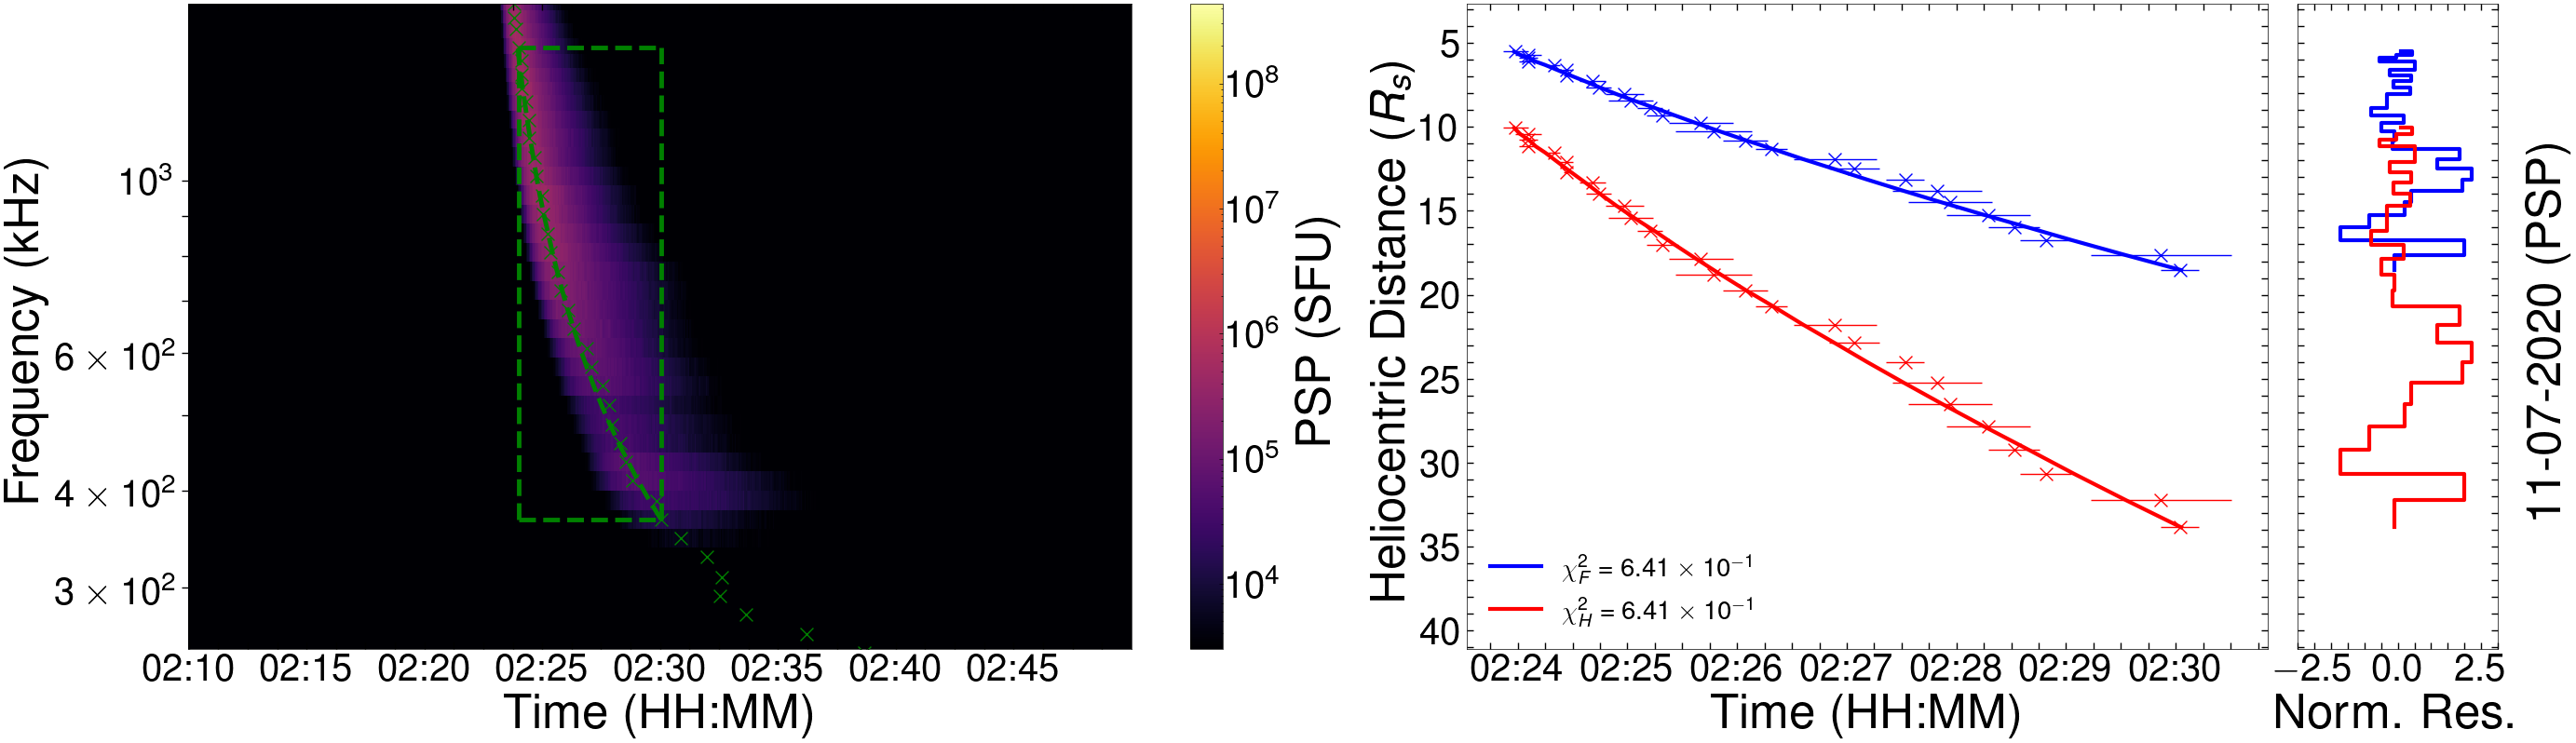

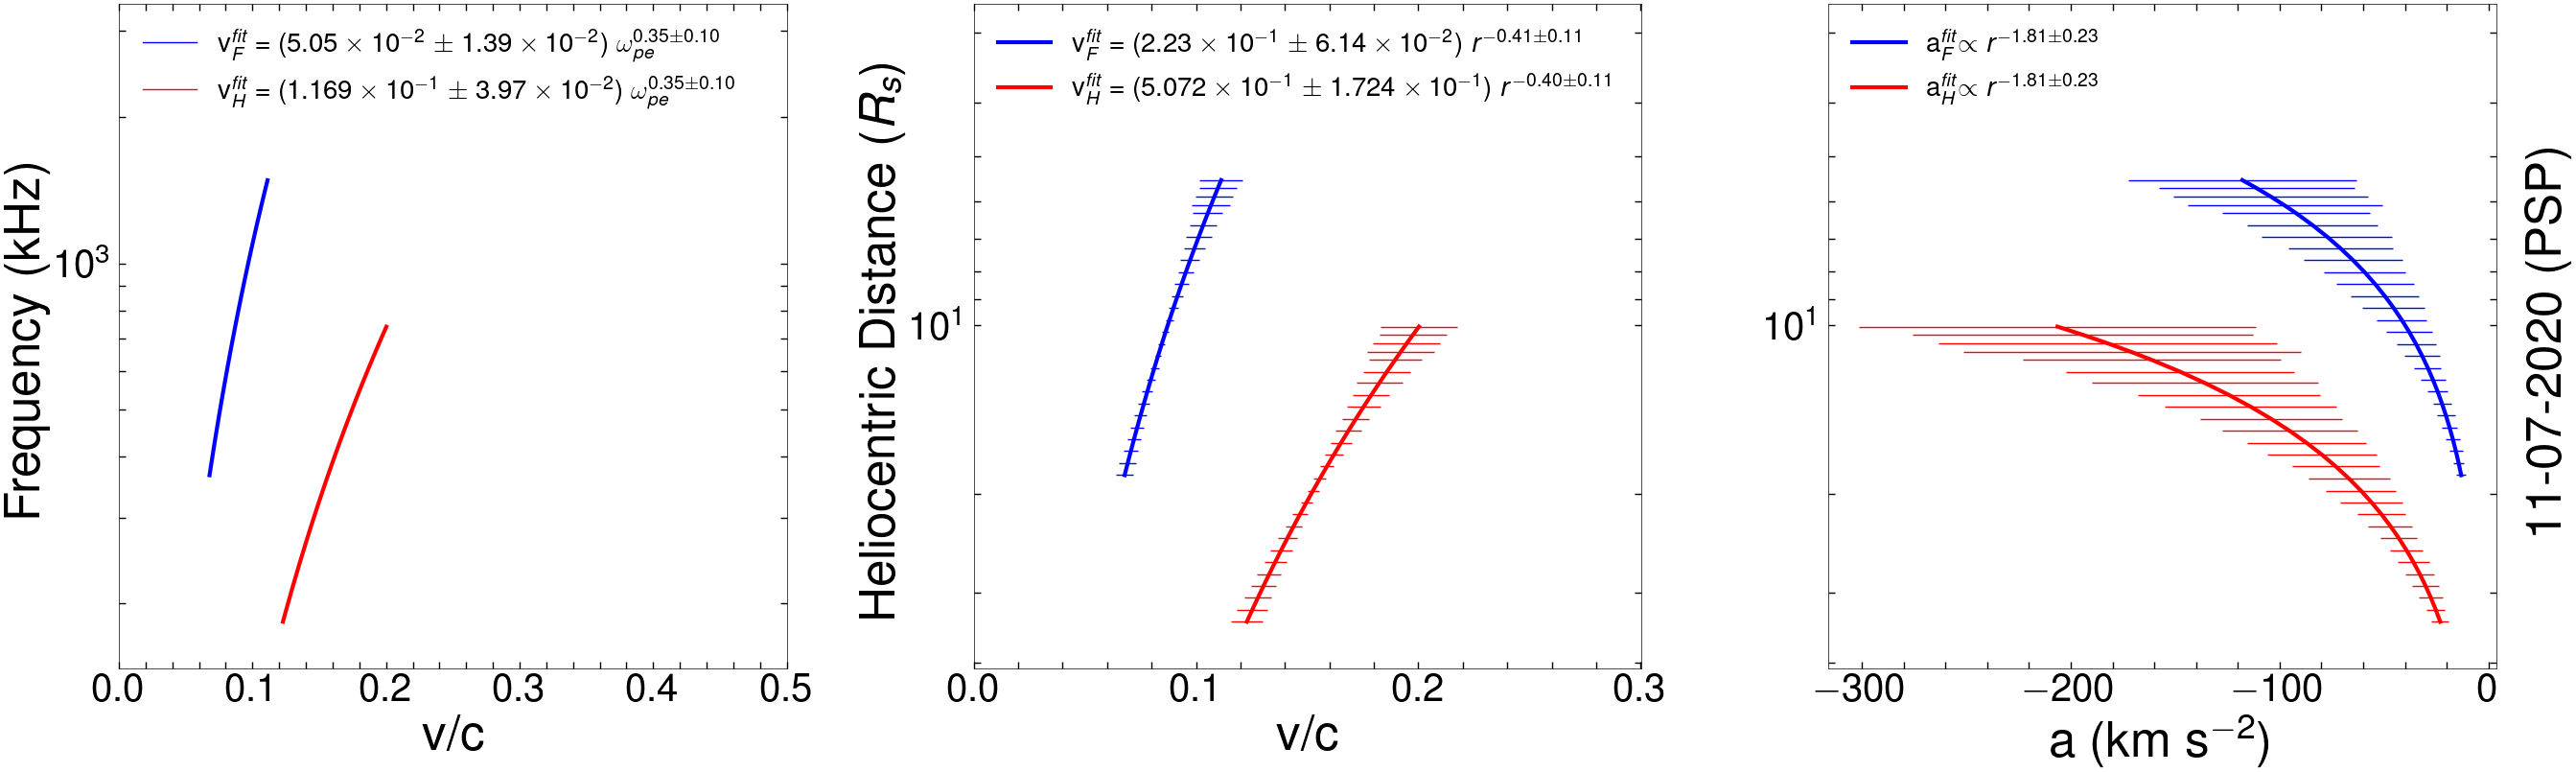

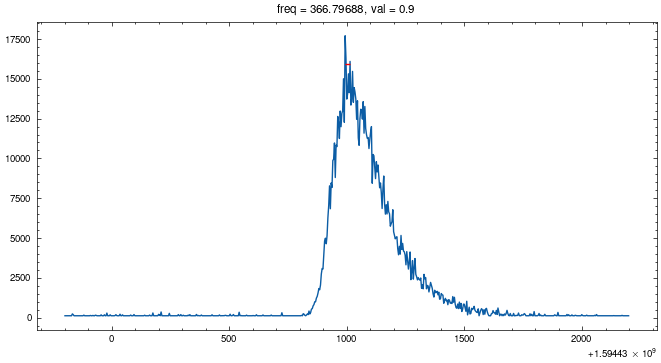

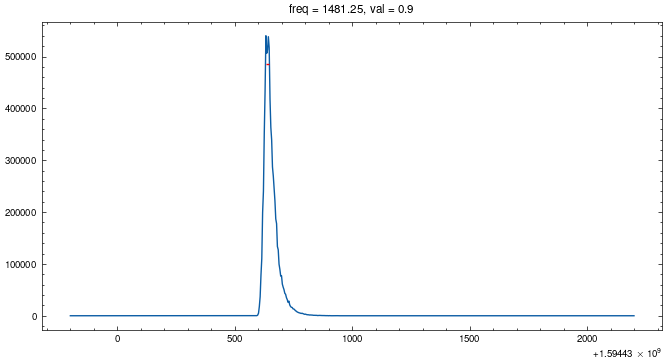

In [6]:
import scienceplots
plt.style.use(['science','nature'])

l=[0] #choose event from date_list
a = [100] #source-spacecraft angle 
f_i = [1500] #start frequency range
f_f = [350] #end frequency range

for d in range(len(l)):    
        type_III_lab(date_list[l[d]], start_list[l[d]], end_list[l[d]], 'psp\\psp_fld_l3_rfs_lfr_' + path_list[l[d]]).dyn_spec('show', 'T', f_i[d], f_f[d], a[d], 0.9) 
        print('Data', l[d])